# Lab 6: Decoding movement from motor cortex recordings

**STATS320: Machine Learning Methods for Neural Data Analysis**

_Stanford University. Winter, 2021._

---

**Team Name:** Team Star

**Team Members:** Tom McIlwain

*Due: 11:59pm Thursday, Feb 25, 2021 via GradeScope*

---

Last week we developed nonlinear _encoder_ models for predicting neural responses to sensory stimuli.  This week we'll develop _decoder_ models for inferring movements from neural spike trains.  One way to decode is via Bayesian inference: if we have a strong encoding model and a good prior distribution on movements, we can combine them to infer the posterior distribution of movements given spikes. This allows us to build constraints into the prior; e.g. that movements tend to be smooth. Ultimately, decoding is just another regression problem, and the Bayesian approach offers just one way of constructing a conditional distribution of movements given spikes. In this lab, we'll start with a Bayesian approach and then take a step back and construct a "direct" decoder that captures the dynamical structure of the Bayesian models while also capturing nonlinear features of the spike train.

We'll use a dataset from the [Shenoy Lab](https://shenoy.people.stanford.edu/) (Stanford University) consisting of a 96-channel Utah array recording from motor cortex of a non-human primate performing a center-out reaching task. The data and a related model are described in (Gilja\*, Nuyujukian\*, et al, 2012).


### References
Gilja, Vikash, Paul Nuyujukian, Cindy A. Chestek, John P. Cunningham, Byron M. Yu, Joline M. Fan, Mark M. Churchland, et al. 2012. “A High-Performance Neural Prosthesis Enabled by Control Algorithm Design.” _Nature Neuroscience_ 15 (12): 1752–57.


# Environment Setup

In [2]:
import numpy as np
from tqdm.auto import trange
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.distributions import MultivariateNormal

# Set some plotting defaults
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "greyish",
                            "orange",
                            "amber",
                            "clay",
                            "pink"])


# Specify that we want our tensors on the CPU and in float32
device = torch.device('cpu')
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

In [3]:
#@title Implement `train_model` function (run this cell!)
def train_model(model, 
                train_dataset, 
                val_dataset,
                objective,
                regularizer=None,
                num_epochs=100, 
                lr=0.1,
                momentum=0.9,
                lr_step_size=25,
                lr_gamma=0.9):
    # progress bars
    pbar = trange(num_epochs)
    pbar.set_description("---")
    inner_pbar = trange(len(train_dataset))
    inner_pbar.set_description("Batch")

    # data loaders for train and validation
    train_dataloader = DataLoader(train_dataset, batch_size=1)
    val_dataloader = DataLoader(val_dataset, batch_size=1)
    dataloaders = dict(train=train_dataloader, val=val_dataloader)

    # use standard SGD with a decaying learning rate
    optimizer = optim.SGD(model.parameters(), 
                          lr=lr, 
                          momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    # Keep track of the best model
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    for epoch in pbar:
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                inner_pbar.reset()
            else:
                model.eval()
            
            # track the running loss over batches
            running_loss = 0
            running_size = 0
            for datapoint in dataloaders[phase]:
                velocity_t = to_t(datapoint['velocity']).squeeze(0)
                spikes_t = to_t(datapoint['spikes']).squeeze(0)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()
                        # compute the model output and loss
                        output_t = model(spikes_t)
                        loss_t = objective(output_t, velocity_t)
                        # only add the regularizer in the training phase
                        if regularizer is not None:
                            loss_t += regularizer(model)

                        # take the gradient and perform an sgd step
                        loss_t.backward()
                        optimizer.step()
                    inner_pbar.update(1)
                else:
                    # just compute the loss in validation
                    output_t = model(spikes_t)
                    loss_t = objective(output_t, velocity_t)

                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1
            
            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())

        # Update the learning rate
        scheduler.step()

        # Update the progress bar
        pbar.set_description("Epoch {:03} Train {:.4f} Val {:.4f}"\
                             .format(epoch, train_losses[-1], val_losses[-1]))
        pbar.update(1)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

## Load the data

This data, kindly shared by Prof. Krishna Shenoy (Stanford), is used in his EE124 class, so it may be familiar to some of you. It's given as a Matlab file with a single struct called `R`. That struct contains data from a number of trials, each consisting of a spike train (`spikeRaster`), a `target`, and a time series of cursor positions (`cursorPos`). There are a bunch of other fields that we won't use for this lab.

Note that the data is not spike sorted. We are simply given the times of putative spikes picked up on each of the 96 channels of the Utah array. 
<!-- Since the electrodes of the Utah are farther apart than those of a Neuropixels probe, it's less common to see spikes from the same neuron on more than one channel.  -->
We might be able to extract some extra information by spike sorting, but to be consistent with previous analyses from the Shenoy lab, we'll just stick with spike counts per channel for this 

The spikes and positions are given in 1ms bins. We'll downsample to 25ms bins, which sacrifices some temporal resolution but will improve our signal-to-noise in the simple Bayesian models and our runtime in all cases.

We pack the results into a list of dictionaries with the following keys:
- `spikes` a (Tx96) array of spike counts for each of the 96 channels where T is the number of time bins in that trial
- `position` a (Tx2) array of cursor positions
- `velocity` a (Tx2) array of estimated cursor velocities
- `condition` a number 0,..,8 specifying the reaching condition (i.e. starting point and target)

In [4]:
%%capture
!wget -nc https://www.dropbox.com/s/b99vsgiz679y5bw/JR_2015-12-04_truncated2.mat

In [5]:
def load_data(bin_size):
    data = loadmat('JR_2015-12-04_truncated2.mat')
    R = data['R'][0]            # the infamous Shenoy lab "R" struct

    # Extract the targets
    targets = np.row_stack([Ri['target'].ravel() for Ri in R])
    unique_targets, conditions = np.unique(targets, return_inverse=True, axis=0)

    # Extract the spikes and positions in 10ms bins
    def bin_spikes(trial):
        spikes =  R[trial]['spikeRaster'].toarray()
        num_neurons, num_frames = spikes.shape
        num_bins = int(np.ceil(num_frames / bin_size))
        pad = np.zeros((num_neurons, num_bins * bin_size - num_frames))
        padded_spikes = np.column_stack([spikes, pad])
        return padded_spikes.reshape(num_neurons, num_bins, bin_size).sum(-1)

    def bin_positions(trial, smooth=20):
        pos = R[trial]['cursorPos'][:2]
        dim, num_frames = pos.shape
        num_bins = int(np.ceil(num_frames / bin_size))
        smooth_pos = gaussian_filter1d(pos, smooth, axis=1)
        f = interp1d(np.arange(num_frames), smooth_pos, 
                     axis=-1, fill_value="extrapolate")
        return f(np.arange(num_bins) * bin_size)

    # Get the spikes, cursor positions, and cursor velocities for each trial
    all_data = []
    for trial in trange(len(R)):
        spk = bin_spikes(trial).T
        pos = bin_positions(trial).T
        vel = np.gradient(pos, axis=0)
        con = conditions[trial]
        all_data.append(dict(spikes=spk, 
                            position=pos, 
                            velocity=vel, 
                            condition=con))

    # Split the data into training and test sets
    train_data = all_data[:400]
    test_data = all_data[400:]
    
    return train_data, test_data

bin_size = 25
train_data, test_data = load_data(bin_size)

## Plot the spike counts and position/velocity times for a single trial

Let's look at one trial. It consists of a time series of spike counts from each channel of the Utah array, as well as a position time series. We also plot the velocity, which is just a first-order estimate of the derivative of the position.

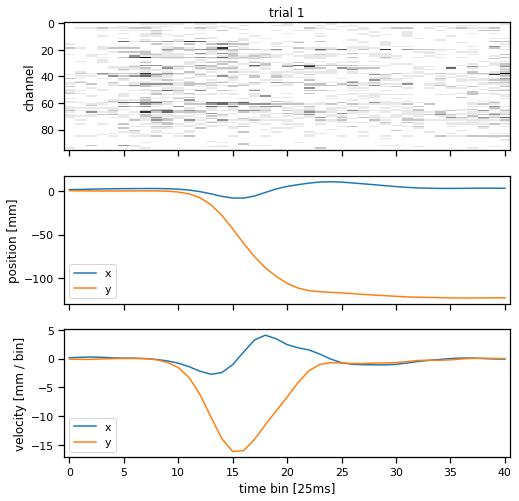

In [6]:
def plot_trial(data, trial):
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

    axs[0].imshow(data[trial]["spikes"].T, 
                interpolation="none", 
                aspect="auto", 
                cmap="Greys")
    axs[0].set_ylabel("channel")
    axs[0].set_title("trial {}".format(trial))

    axs[1].plot(data[trial]["position"][:, 0], label='x')
    axs[1].plot(data[trial]["position"][:, 1], label='y')
    axs[1].set_ylabel("position [mm]")
    axs[1].legend()

    axs[2].plot(data[trial]["velocity"][:, 0], label='x')
    axs[2].plot(data[trial]["velocity"][:, 1], label='y')
    axs[2].set_xlabel("time bin [{}ms]".format(bin_size))
    axs[2].set_ylabel("velocity [mm / bin]")
    axs[2].legend()

plot_trial(train_data, 1)

## Plot the cursor positions across all trials

Plot the reach directions color-coded by the condition type. Most conditions start at the center and move outward to a target. One condition type (gray) starts at the perimeter and moves to the center.

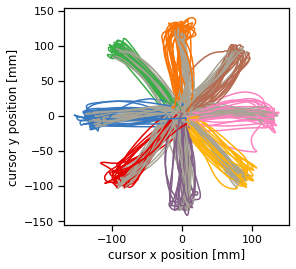

In [7]:
def plot_reach_trajectories(data):
    for d in data:
        plt.plot(d["position"][:, 0], 
                 d["position"][:, 1], 
                 color=palette[d["condition"]])
        
    plt.xlabel("cursor x position [mm]")
    plt.ylabel("cursor y position [mm]")
    plt.gca().set_aspect("equal")

plot_reach_trajectories(train_data)

# Part 1: Implement a simple Bayesian decoder

Our first model is an extremely simple Bayesian decoder.  Let $x_t^{(\ell)} \in \mathbb{R}^2$ denote the **cursor velocity** at time $t$ on trial $\ell$. Likewise, let $y_t^{(\ell)} \in \mathbb{R}^{96}$ denote the spike count measured on the 96-channel array at time $t$ on trial $\ell$. Let $T_\ell$ denote the number of time bins of trial $\ell$, and let $L$ denote the total number of trials. 

We will estimate the posterior distribution over velocity under the following model,
\begin{align}
x_t^{(\ell)} &\sim \mathcal{N}(0, Q) \\
y_t^{(\ell)} \mid x_t^{(\ell)} &\sim \mathcal{N}(C x_t^{(\ell)} + d, R).
\end{align}
The model has the following parameters,
- $Q \in \mathbb{R}^{2 \times 2}$: the prior covariance of the velocity
- $C \in \mathbb{R}^{96 \times 2}$: the _emission_ matrix
- $d \in \mathbb{R}^{96}$: the _emission_ bias
- $R \in \mathbb{R}^{96 \times 96}$: the _emission_ covariance
Note that $Q$ and $R$ are positive definite matrices.

As we derived in class, the posterior distribution of the velocity given the spike counts is,
\begin{align}
p(x_t^{(\ell)} \mid y_t^{(\ell)}) &= \mathcal{N}(\mu_t, \Sigma) \\
\Sigma &= J^{-1}  
& \mu_t &= J^{-1} h_t \\
J &= Q^{-1} + C^\top R^{-1} C &
h_t &= C^\top R^{-1}(y_t^{(\ell)} - d),
\end{align}
where $(\mu_t, \Sigma)$ are the posterior mean and covariance, respectively, and $(J, h_t)$ are the _natural_ (aka _information-form_) parameters. 

To be consistent with the subsequent parts of the lab, we will formulate the model as a conditional distribution over the entire time series of velocities, $\mathbf{x}^{(\ell)} = (x_1^{(\ell)}, \ldots, x_{T_\ell}^{(\ell)}) \in \mathbb{R}^{T \times 2}$ given the entire time series of spike counts $\mathbf{y}^{(\ell)} \in \mathbb{R}^{T \times 96}$. Since the simple model factors into a product of Gaussians for each time bin, and since each Gaussian has the same covariance, the full posterior distribution is,
\begin{align}
p(\mathbf{x}^{(\ell)} \mid \mathbf{y}^{(\ell)}) 
&= \prod_{t=1}^{T_\ell} p(x_t^{(\ell)} \mid y_t^{(\ell)}) \\
&= \mathcal{N}\left( \mathrm{vec}(\mathbf{x}^{(\ell)}) \, \bigg| \,
    \begin{bmatrix} \mu_1 \\ \vdots \\ \mu_{T_\ell} \end{bmatrix},
    \begin{bmatrix} \Sigma & & \\ & \ddots & \\ & & \Sigma \end{bmatrix} 
    \right).
\end{align}

In Part 1, you'll estimate the parameters of this model, $\{Q, C, d, R\}$ and implement it as a PyTorch module.

## Problem 1a: Estimate the prior covariance $Q$

Estimate the prior covariance, assuming the velocity is zero mean, as 
\begin{align}
\hat{Q} &= \frac{1}{\sum_{\ell = 1}^L T_\ell} \left(\sum_{\ell=1}^L \sum_{t=1}^{T_\ell} x_t^{(\ell)} (x_t^{(\ell)})^\top \right).
\end{align}

In [8]:
def estimate_basic_prior_prms(train_data):
    """
    Estimate \hat{Q} from the training data.
    """
    ###
    # YOUR CODE BELOW
    sum_T = 0
    vel_sums = np.zeros((2,2))
    for trial in train_data:
      velocity = trial['velocity']
      T = velocity.shape[0]
      for t in range(T):
        vel_sums += velocity[t,:, np.newaxis] @ velocity[t,:, np.newaxis].T
      sum_T += T
    Q_hat = vel_sums / sum_T
    #
    ###
    return Q_hat

Q_hat = estimate_basic_prior_prms(train_data)
print(Q_hat)
assert np.allclose(Q_hat, np.array([[15.6646, -0.9956],
                                    [-0.9956, 16.4991]]),
                   atol=1e-4)

[[15.66467082 -0.99565276]
 [-0.99565276 16.49912847]]


## Problem 1b: Estimate the encoding model parameters

Estimate $C$, $d$, and $R$ by fitting a linear regression to the training velocity and spikes.

You can use the `LinearRegression` class from `sklearn.linear_model` (imported above), `scipy.linalg.lstsq`, or you can do it manually. Your choice!



In [9]:
from scipy.linalg import lstsq
def estimate_emission_prms(train_data):
    """Estimate \hat{C}, \hat{d}, and \hat{R} from the training data.
    """
    ###
    # YOUR CODE BELOW
    Xs = np.concatenate([trial['velocity'] for trial in train_data])
    ys = np.concatenate([trial['spikes'] for trial in train_data])

    reg = LinearRegression()
    reg.fit(Xs, ys)
    residuals = ys - reg.predict(Xs)
    
    C_hat = reg.coef_
    d_hat = reg.intercept_
    R_hat = residuals.T @ residuals / len(residuals)
    #
    ###
    return C_hat, d_hat, R_hat

C_hat, d_hat, R_hat = estimate_emission_prms(train_data)
assert np.allclose(C_hat.sum(), -0.1172, atol=1e-4)
assert np.allclose(C_hat.std(), 0.0121, atol=1e-4)
assert np.allclose(d_hat.sum(), 39.7506, atol=1e-1)
assert np.allclose(d_hat.std(), 0.3210, atol=1e-4)
assert np.allclose(R_hat.sum(), 587.7989, atol=1e-1)
assert np.allclose(R_hat.std(), 0.1022, atol=1e-4)

## Problem 1c: Implement the simple decoder model

Implement the simple decoder as a PyTorch `Module`. We won't be fitting any parameters (you just estimated them above!), but implementing it this way will allow us to compare directly to the model developed in Part 3.

Specifically, complete the `forward` function to compute `J`, `h`, `mu`, and `Sigma`. The functions `torch.solve` and `torch.inverse` will be useful. 

_Note: there are generally more numerically stable/efficient approaches than directly computing a matrix inverse&mdash;solve is almost always preferable!&mdash;but for this lab go ahead and call `torch.inverse` to compute `Sigma`._

In [10]:
class SimpleDecoder(nn.Module):
    def __init__(self, Q, C, d, R):
        super(SimpleDecoder, self).__init__()
        
        # Store the parameters as tensors
        self.Q = to_t(Q)
        self.C = to_t(C)
        self.d = to_t(d)
        self.R = to_t(R)
        
    def forward(self, spikes):
        """
        spikes: T x 96 array of spikes for a single trial
        returns: (mu, Sigma) where 
            - mu is the (T x 2) posterior mean of the velocity
            - Sigma is the (2 x 2) posterior covariance (the same for all bins)
        """
        # Get the model parameters so we don't always have to reference self
        Q, C, d, R = self.Q, self.C, self.d, self.R

        # Convert spikes to tensor, if they're not already
        Y = to_t(spikes)
        T, _ = Y.shape

        ###
        # YOUR CODE BELOW
        #
        J = torch.inverse(Q) + C.T @ torch.inverse(R) @ C    # 2x2 tensor
        Sigma = torch.inverse(J) # 2x2 tensor
        h = (Y - d) @ torch.inverse(R) @ C    # Tx2 tensor
        mu = h @ Sigma.T    # Tx2 tensor
        #
        ###

        # Convert Sigma to a 2T x 2T block diagonal matrix for consistency
        # with the models in Parts 2 and 3
        assert Sigma.shape == (2, 2)
        Sigma = torch.block_diag(*(Sigma * torch.ones(T, 2, 2)))

        # Return the mean and covariance
        return mu, Sigma
        

# Instantiate the model
Q_hat = estimate_basic_prior_prms(train_data)
C_hat, d_hat, R_hat = estimate_emission_prms(train_data)
simple_decoder = SimpleDecoder(Q_hat, C_hat, d_hat, R_hat)

## Problem 1d: Compute the multivariate normal log probability

Write a function to compute the (average negative) log probability under the a multivariate normal distribution,
\begin{align}
p(\mathbf{x}^{(\ell)} \mid \mathbf{y}^{(\ell)}) 
&= \prod_{t=1}^{T_\ell} p(x_t^{(\ell)} \mid y_t^{(\ell)}) \\
&= \mathcal{N}\left( \mathrm{vec}(\mathbf{x}^{(\ell)}) \, \bigg| \,
    \boldsymbol{\mu}, \mathbf{\Sigma}
    \right).
\end{align}
where $\mathrm{vec}(\mathbf{x}^{(\ell)}) \in \mathbb{R}^{2T}$ is the vectorized array of velocities, $\boldsymbol{\mu} \in \mathbb{R}^{2T}$ is the mean, and $\boldsymbol{\Sigma} \in \mathbb{R}^{2T \times 2T}$ is the covariance matrix.

The function will take in the velocity and mean as shape (T,2) tensors, so you'll have to do some flattening. We'll negate and normalize for you.

In [11]:
def mvn_loss(prms, velocity):
    """Compute the average negative log-likelihood under a 
    multivariate normal model.

    prms: tuple containing (mean, cov) where:
        mean: T x 2 tensor of predicted velocity mean
        cov:  2T x 2T tensor of predicted velocity covariance
    velocity: T x 2 array of measured velocity
    returns: average negative log likelihood (mean over all spikes)
    """
    mean, cov = prms
    velocity = to_t(velocity)
    
    ###
    # YOUR CODE BELOW
    ll = torch.distributions.MultivariateNormal(
        mean.reshape(-1), cov).log_prob(velocity.reshape(-1))
    ###
    return -ll / velocity.numel()
    
assert torch.isclose(
    mvn_loss(simple_decoder(train_data[0]['spikes']), 
             train_data[0]['velocity']),
    torch.tensor(2.6651), atol=1e-4)

## Plot the decoded positions
That's it! No more fitting required. You already estimated the parametes in Problems 1a and 1b. Now we'll decode the velocities from the test set and integrate them to get positions that we can compare to the true cursor trajectories.

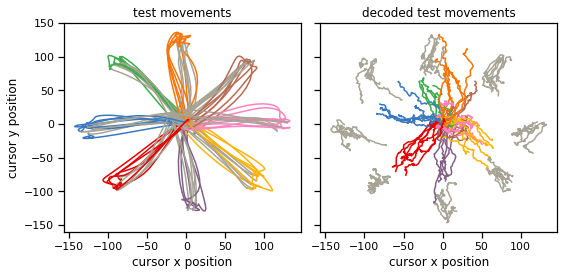

In [12]:
def plot_decoder(test_data, decoder):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    for trial in trange(len(test_data)):
        spikes = test_data[trial]["spikes"]
        position = test_data[trial]["position"]
        cond = test_data[trial]["condition"]
        
        # decode velocity and integrate to get position
        dec_velocity = from_t(decoder(spikes)[0])
        dec_position = position[0] + np.cumsum(dec_velocity, axis=0)

        axs[0].plot(position[:, 0], position[:, 1], color=palette[cond])
        axs[1].plot(dec_position[:, 0], dec_position[:, 1], color=palette[cond])
    
    axs[0].set_title("test movements")
    axs[0].set_xlabel("cursor x position")
    axs[0].set_ylabel("cursor y position")
    axs[1].set_xlabel("cursor x position")
    axs[1].set_title("decoded test movements")
    plt.tight_layout()

plot_decoder(test_data, simple_decoder)

## Problem 1e: [Short answer] Discuss your results

_Answer below this line_

---

Using a simple bayesian decoder like the one implemented above does not achieve great results. The cursor position of the decoded test movements is very noisy and much less stable (i.e. cursor not going in a straight line) because the next predicted velocity is not correlated to the previous velocity, and the velocity seems to be smaller in magnitude compared to the test movements based on the fact that the cursor is never reaching the target or fully going back to center.

# Part 2: Bayesian decoding with a linear dynamical system prior

The simple model failed to account for any temporal correlations in the velocities. This followed from the fact that both the prior and the likelihood were independent across time bins. In this section, we'll address this shortcoming by building temporal dependencies into the prior.

Consider the following model instead,
\begin{align}
x_1^{(\ell)} &\sim \mathcal{N}(0, Q_0) \\
x_t^{(\ell)} &\sim \mathcal{N}(A x_{t-1}, Q) & \text{for }  t&=2,\ldots, T\\
y_t^{(\ell)} \mid x_t^{(\ell)} &\sim \mathcal{N}(C x_t^{(\ell)} + d, R) 
 & \text{for }  t&=1,\ldots, T.
\end{align}

Under this model, the velocity $x_t^{(\ell)}$ is a linear function of the preceding velocity with additive Gaussian noise. This is called a _linear dynamical system_ (LDS). These autoregressive dependencies of the LDS lead to correlations across time in the posterior. 

## Problem 2a [Math]: Derive the natural parameters of the LDS posterior

As we discussed in class, the posterior distribution of the LDS is also a multivariate Gaussian, 
\begin{align}
p(\mathbf{x}^{(\ell)} \mid \mathbf{y}^{(\ell)}) 
&= \mathcal{N}\left( \mathrm{vec}(\mathbf{x}^{(\ell)}) \, \bigg| \,
    \boldsymbol{\mu}, \mathbf{\Sigma}
    \right).
\end{align}
but here the covariance matrix $\boldsymbol{\Sigma} \in \mathbb{R}^{2T \times 2T}$ is no longer block diagonal. Instead, we have,
\begin{align}
\boldsymbol{\Sigma} &= \mathbf{J}^{-1} &
\boldsymbol{\mu} &= \mathbf{J}^{-1} \mathbf{h} 
\end{align}
where $\mathbf{J} \in \mathbb{R}^{2T \times 2T}$ is a block tridiagonal matrix and $\mathbf{h} \in \mathbb{R}^{2T}$ is a vector,
\begin{align}
\mathbf{J} &=
\begin{bmatrix}
J_{11} & J_{21}^\top &    &           &                \\
J_{21} & J_{22} &  \ddots &           &                \\
       & \ddots & \ddots  & \ddots    &                \\
       &        & \ddots  & \ddots    & J_{T,T-1}^\top \\
       &        &         & J_{T,T-1} & J_{T,T}
\end{bmatrix}
&
\mathbf{h} &=
\begin{bmatrix}
h_1 \\
h_2 \\
\vdots \\
h_T
\end{bmatrix}
\end{align}
Derive the form of the natural parameters of the posterior distribution, including:
- the diagonal blocks $J_{tt}$ (including the special cases for $t=1$ and $t=T$), 
- the lower diagonal blocks $J_{t,t-1}$, and
- the linear terms $h_t$. 

To do so, apply Bayes rule, expanding the joint probability, and collecting terms to write the posterior as a multivariate normal distribution on $\mathbf{x}^{(\ell)}$.

_Answer below this line_

---

\begin{align}
p(\mathbf{x|y}) \propto p(\mathbf{y|x})p(\mathbf{x})
\end{align}
with
\begin{align}
p(\mathbf{y|x}) = \prod_{t=1}^Tp(y_t|x_t)
\end{align}
\begin{align}
p(\mathbf{y|x}) \propto \exp[(-\frac{1}{2}\sum_{t=1}^T{y^T_tR^{-1}y_t})  + (\sum_{t=1}^T{(Cx_t + d)^TR^{-1}y_t}) + (-\frac{1}{2}\sum_{t=1}^T{(Cx_t + d)^TR^{-1}(Cx_t + d)}]
\end{align}
and
\begin{align}
p(\mathbf{x}) = p(x_1)\prod_{t=2}^T{p(x_t|x_{t-1}})
\end{align}
\begin{align}
p(\mathbf{x}) \propto \exp[(-\frac{1}{2}x_1^T(Q_0^{-1}+A^TQ^{-1}A)x1) + (-\frac{1}{2}\sum_{t=2}^{T-1}x_t^T(Q^{-1}+A^TQ^{-1}A)x_t)+(-\frac{1}{2}x_T^TQ^{-1}x_T)+(\sum_{t=2}^Tx_t^TQ^{-1}Ax_{t-1})]
\end{align}
Combining to get $J$ terms
\begin{align}
J_{tt} = Q^{-1} + A^TQ^{-1}A + C^TR^{-1}C
\end{align}
$t=1$
\begin{align}
J_{11} = Q_0^{-1} + A^TQ^{-1}A + C^TR^{-1}C
\end{align}
$t=T$
\begin{align}
J_{TT} = Q^{-1} + C^TR^{-1}C
\end{align}
lower diagonal block
\begin{align}
J_{t,t-1} = -Q^{-1}A
\end{align}
linear term $h_t$
\begin{align}
h_t = C^TR^{-1}(y_t-d)
\end{align}

## Problem 2b: Estimate the velocity dynamics

Write a function to estimate the prior parameters $\hat{Q}_0$, $\hat{A}$, and $\hat{Q}$. Estimate $\hat{Q}_0$ as the empirical variance of the initial velocity (similar to Problem 1a), and estimate $\hat{A}$ and $\hat{Q}$ via linear regression (similar to Problem 1b).


In [20]:
def estimate_dynamics_prms(train_data):
    """
    Estimate the prior parameters Q0, A, and Q, as described above.
    """
    ###
    # YOUR CODE BELOW
    #
    vel_1 = np.concatenate([trial['velocity'][0:1] for trial in train_data])
    vel_t_1 = np.concatenate([trial['velocity'][:-1] for trial in train_data])
    vel_t = np.concatenate([trial['velocity'][1:] for trial in train_data])

    Q0_hat = vel_1.T @ vel_1 / len(vel_1)

    reg = LinearRegression(fit_intercept=False).fit(vel_t_1, vel_t)
    A_hat = reg.coef_
    residuals = vel_t - reg.predict(vel_t_1)
    Q_hat = residuals.T @ residuals / len(residuals)
    #
    ###
    return Q0_hat, A_hat, Q_hat

Q0_hat, A_hat, Q_hat = estimate_dynamics_prms(train_data)

## A helper function to construct a symmetric block tridiagonal matrix from its parts

In [21]:
def symm_block_tridiag(J_diag, J_lower_diag):
    """
    Helper function to construct a symmetric block tridiagonal matrix
    from its diagonal blocks (J_diag) and lower diagonal blocks (J_lower_diag).
    The shape of the output is inferred from the shapes of the inputs

    J_diag: T x D x D tensor of diagonal blocks
    J_lower_diag: T-1 x D x D tensor of lower diagonal blocks

    returns: TD x TD symmetric block tridiagonal matrix
    """
    T, D, _ = J_diag.shape
    assert J_diag.shape[2] == D
    assert J_lower_diag.shape == (T-1, D, D)

    J = torch.block_diag(*J_diag)
    J[D:, :-D] += torch.block_diag(*J_lower_diag)
    J[:-D, D:] += torch.block_diag(*torch.transpose(J_lower_diag, 1, 2))
    return J

## Problem 2c: Implement the LDS decoder

Implement the LDS decoder as a PyTorch module, using your derivations from Problem 2a and the helper function above to construct the big $\mathbf{J}$ matrix and $\mathbf{h}$ vector. Then use `torch.invert` to convert the natural parameters to mean parameters $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$. 

As in Part 1, return $\boldsymbol{\mu}$ as a `T x 2` tensor and $\boldsymbol{\Sigma}$ as a `2T x 2T` tensor.

**Note**: Inverting $\mathbf{J}$ naively takse $O(T^3)$ operations since it's a $2T \times 2T$ matrix.  We can get this down to $O(T)$ using the Kalman smoother&mdash;a dynamic programming algorithm. We'll talk more about this in class next week or the week after. For now, just pay the cubic price since these matrices aren't that big anyway.

In [25]:
class LDSDecoder(nn.Module):
    def __init__(self, Q0, A, Q, C, d, R):
        self.Q0 = to_t(Q0)
        self.A = to_t(A)
        self.Q = to_t(Q)
        self.C = to_t(C)
        self.d = to_t(d)
        self.R = to_t(R)
        super(LDSDecoder, self).__init__()
        
    def forward(self, spikes):
        """
        spikes: T x num_channels array of spikes for a single trial
        returns: (mu, Sigma) where 
            - mu is the (T x 2) posterior mean of the velocity
            - Sigma is the (2 x 2) posterior covariance (the same for all bins)
        """
        # Get the model parameters so we don't always have to reference self
        Q0, A, Q, C, d, R = self.Q0, self.A, self.Q, self.C, self.d, self.R

        # Convert spikes to tensor, if they're not already
        Y = to_t(spikes)
        T, _ = Y.shape

        # Initialize the diagonal and lower diagonal blocks of J
        J_diag = torch.zeros(T, 2, 2)
        J_lower_diag = torch.zeros(T-1, 2, 2)

        ###
        # YOUR CODE BELOW
        #
        ATQA = A.T @ torch.inverse(Q) @ A
        CTRC = C.T @ torch.inverse(R) @ C
        QI = torch.inverse(Q)

        # Fill in the diagonal blocks of J (TXDXD)
        J_11 = torch.inverse(Q0) + ATQA + CTRC
        J_tt = QI + ATQA + CTRC
        J_TT = QI + CTRC
      
        J_diag[0] = J_11
        J_diag[1:T-1] = J_tt.unsqueeze(0).repeat(T-2, 1, 1)
        J_diag[T-1] = J_TT
        
        # Fill in the lower diagonal blocks of J
        J_t_t_1 = -QI @ A
        J_lower_diag[:] = J_t_t_1.unsqueeze(0).repeat(T-1, 1, 1)

        # Construct the full J matrix
        J = symm_block_tridiag(J_diag, J_lower_diag)

        # Construct the full h vector
        h = (Y - d) @ torch.inverse(R).T @ C
        
        # Convert to standard parameters
        Sigma = torch.inverse(J)
        mu = (Sigma @ h.flatten()).reshape(T, 2)
        #
        ###

        return mu, Sigma
        
# Instantiate the decoder
Q0_hat, A_hat, Q_hat = estimate_dynamics_prms(train_data)
C_hat, d_hat, R_hat = estimate_emission_prms(train_data)
lds_decoder = LDSDecoder(Q0_hat, A_hat, Q_hat, C_hat, d_hat, R_hat)

## Plot the decoded positions
Once again, that's it! No more fitting required. You already estimated the parametes in Problems 1a and 1b. Now we'll decode the velocities from the test set and integrate them to get positions that we can compare to the true cursor trajectories.

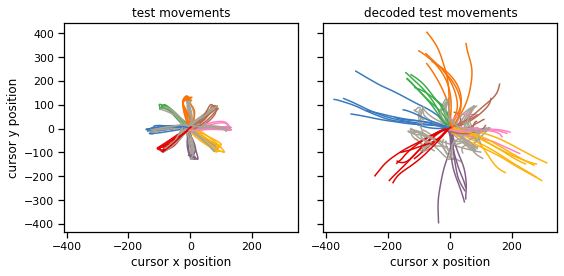

In [26]:
plot_decoder(test_data, lds_decoder)

## Problem 2d: [Short answer] Discuss your results

_Answer below this line_

---

The cursor position is now much smoother as the velocity is time-dependent, meaning we are now accounting for temporal correlations of velocity. This presents us with velocities that are partially based on previous velocity, creating a smoother trajectory. However, the magnitudes of the velocities still seem too large, and when the monkey is moving from out to center, the velocity does not seem to be pointing in the correct direction.

# Part 3: Direct decoding with a LDS-inspired model

One of the limitations of the LDS in Part 2 is that it treated the spikes as a **linear function** of the instantaneous velocity with **additive Gaussian** noise. We could work on the encoder and instead substitute a Poisson GLM for $p(y_t^{(\ell)} \mid x_t^{(\ell)})$, for example, but that would destroy the conjugacy of the model, and the resulting posterior distribution would no longer have a closed form. 

A common approach to Bayesian inference in "non-conjugate" models is to approximate the resulting posterior with a Gaussian distribution; e.g. via Laplace approximation. Note that the Gaussian approximation to the non-conjugate model's posterior is not the same as the posterior under a linear Gaussian model&mdash;it is influenced by the nonlinear likelihood model, for instance.

That said, if we're ultimately going to approximate the posterior as a Gaussian, why not just _learn_ to output a Gaussian distribution whose mean and covariance are some function of the spikes $\mathbf{y}^{(\ell)}$? There are a few challenges:
- The output of the model would include a $2T_\ell \times 2T_\ell$ covariance matrix, which grows quadratically with the length of the input.
- Moreover, we want to handle arbitrary length time series ($T_\ell$ is not fixed). 

To handle these two concerns, we'll develop a _structured_ prediction model that constrains the Gaussian covariance matrix to mimic that of an LDS. In particular, we'll constrain the inverse covariance matrix (aka the precision matrix) to be block-tridiagonal, as in the LDS. However, we'll allow the diagonal blocks of $\mathbf{J}$ and the entries in $\mathbf{h}$ to be learned, nonlinear functions of the spike train.

Concretely, we'll implement the following model:
\begin{align}
p(\mathbf{x}^{(\ell)} \mid \mathbf{y}^{(\ell)}) 
&= \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \\
\boldsymbol{\Sigma} &= \mathbf{J}^{-1}\\
\boldsymbol{\mu} &= \mathbf{J}^{-1} \mathbf{h}
\end{align}
where $\mathbf{J}$ and $\mathbf{h}$ have blocks,
\begin{align}
J_{t,t-1} &= -Q^{-1} A \\
J_{tt} &= Q^{-1} + A^\top Q^{-1} A + f(\mathbf{y}_{t-\Delta:t+\Delta}^{(\ell)}) \\
h_{t} &= g(\mathbf{y}_{t-\Delta:t+\Delta}^{(\ell)})
\end{align}
Here, $f$ and $g$ are learned functions of the data in a window of size $2\Delta$ around the current bin. 
(Note that you'll have to handle edge cases in $J_{11}$ and $J_{TT}$ as in Part 2.)

This model retains the LDS prior that couples the velocities via a linear Gaussian model, but it allows richer functions of the data in place of the likelihood. Let's see if we can get this model to improve on the decoders above!


## Problem 3a: Implement a structured decoder with features from a CNN

Implement the functions $f$ and $g$ above by first passing the spikes through a `Conv1d` layer with 96 input channels, `interm_dim` output channels, a kernel of size `kernel_size`, and half that padding on either end to obtain a `T x interm_dim` output. Pass the output through a `relu` and then apply two separate linear layers. 
1. The first linear layer gives you a `Tx2` tensor containing the linear coefficients $h_t$.
2. The second layer gives you a `Tx2` tensor which you'll then pass through a softplus to make non-negative. Add those non-negative entries to the diagonals of your precision blocks $J_{tt}$. 

In [41]:
class StructuredDecoder(nn.Module):
    def __init__(self, Q0, A, Q, 
                 num_channels=96,
                 kernel_size=5,
                 interm_dim=10):
        super(StructuredDecoder, self).__init__()
        self.Q0 = to_t(Q0)
        self.A = to_t(A)
        self.Q = to_t(Q)
        
        ###
        # Initialize the learnable layers
        # YOUR CODE BELOW
        self.conv = nn.Conv1d(num_channels, interm_dim, kernel_size, 
                              padding=int(kernel_size/2))
        self.relu = nn.ReLU()
        self.linear_h = nn.Linear(interm_dim, 2)
        self.linear_J = nn.Linear(interm_dim, 2)
        self.softplus = nn.Softplus()
        #
        ###
        
    def forward(self, spikes):
        """
        spikes: T x 96 array of spikes for a single trial
        returns: (mu, Sigma) where 
            - mu is the (T x 2) posterior mean of the velocity
            - Sigma is the (2T x 2T) posterior covariance matrix
        """
        # Get the model parameters so we don't always have to reference self
        Q0, A, Q = self.Q0, self.A, self.Q

        # Convert spikes to tensor, if they're not already
        Y = to_t(spikes)
        T, _ = Y.shape

        # Initialize the diagonal and lower diagonal blocks of J
        J_diag = torch.zeros(T, 2, 2)
        J_lower_diag = torch.zeros(T-1, 2, 2)

        ###
        # YOUR CODE BELOW
        #
        conv_result = self.conv(Y.T.unsqueeze(0)).squeeze()
        result = self.relu(conv_result).T

        # h vector
        h = self.linear_h(result)

        # J offsets
        J_offset = self.softplus(self.linear_J(result))

        # Building J matrix
        QI = torch.inverse(Q)
        ATQA = A.T @ QI @ A

        # Fill in the diagonal blocks of J
        J_11 = torch.inverse(Q0) + ATQA
        J_tt = QI + ATQA
        J_TT = QI
      
        J_diag[0] = J_11
        J_diag[1:T-1] = J_tt.unsqueeze(0).repeat(T-2, 1, 1)
        J_diag[T-1] = J_TT
        
        # Fill in the lower diagonal blocks of J
        J_t_t_1 = -QI @ A
        J_lower_diag[:] = J_t_t_1.unsqueeze(0).repeat(T-1, 1, 1)

        # Construct the full J matrix
        J = symm_block_tridiag(J_diag, J_lower_diag)
        J += torch.diag(J_offset.flatten())

        Sigma = torch.inverse(J)
        mu = (Sigma @ h.flatten()).reshape(T, 2)
        #
        ###
        assert torch.all(torch.isfinite(mu))
        assert torch.all(torch.isfinite(Sigma))
        return mu, Sigma
        
torch.manual_seed(0)
struct_decoder = StructuredDecoder(Q0_hat, A_hat, Q_hat)
mvn_loss(struct_decoder(train_data[0]["spikes"]),
         train_data[0]["velocity"])

tensor(6.6286, grad_fn=<DivBackward0>)

## Train the model

Training structured decoder model. This should take about 4 minutes...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


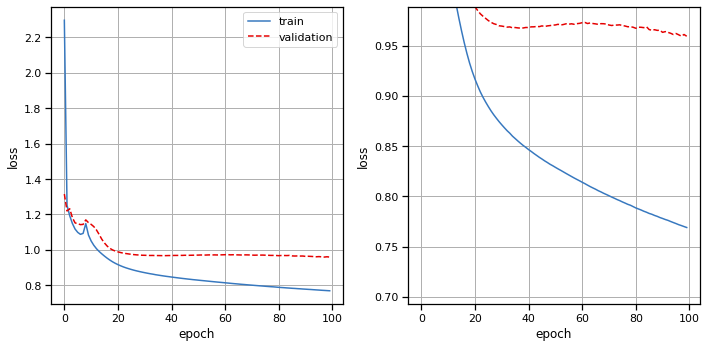

In [42]:
print("Training structured decoder model. This should take about 4 minutes...")
train_losses, val_losses = train_model(struct_decoder, 
                                       train_data[:300], 
                                       train_data[300:], 
                                       mvn_loss, 
                                       lr=1e-4, 
                                       lr_step_size=100)

# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("loss")
axs[1].set_ylim(top=val_losses[20])
axs[1].grid(True)

plt.tight_layout()

## Plot the decoded movements 

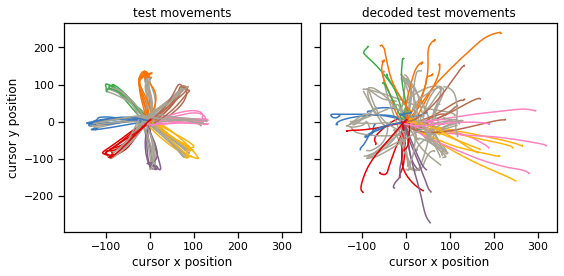

In [43]:
plot_decoder(test_data, struct_decoder)

## Problem 3b: Compute and report the test loss for all 3 decoders

Compute the test loss for all three models, averaging the loss from each test trial. 

In [51]:
def compute_test_loss(decoder):
    """
    Compute the average loss on the test set
    """
    ###
    # YOUR CODE BELOW
    avg_nll = 0
    for trial in train_data:
      vel = trial['velocity']
      spikes = trial['spikes']
      avg_nll += mvn_loss(decoder(spikes), vel)
    avg_nll /= len(train_data)
    #
    ###
    return avg_nll
    
print("Average test loss:")
print("Simple:     {:.4f}".format(from_t(compute_test_loss(simple_decoder))))
print("LDS:        {:.4f}".format(from_t(compute_test_loss(lds_decoder))))
print("Structured: {:.4f}".format(from_t(compute_test_loss(struct_decoder))))


Average test loss:
Simple:     2.6924
LDS:        1.2091
Structured: 0.8454


# Part 4: Discussion

Write a few paragraphs summarizing what you learned in this lab. 

Here are a few prompts to consider (no need to respond to all; these are just to spark some ideas):

- Do the numerical results match your intuitive judgements of decoding quality?
- How might you generalize the structured decoder?
- What might you expect if you tried to directly decode cursor position instead of velocity?
- Decoding performance could be limited by either the raw amount of information about movement contained in the neural activity, or by the particular form of decoder that we employed. What do you think the limiting factor is in this lab?
- We only plotted the mean of the decoder, $\boldsymbol{\mu}$. What could you learn from the covariance $\boldsymbol{\Sigma}$?
- Are the weights of the structured decoder in Part 3 interpretable?
- Suppose we wanted to use the decoder to control a prosthetic limb and we needed it to work for months or years at a time. Would you expect the same decoder parameters to work throughout that time course, and if not, how might you adapt the decoder over time to maintain or potentially even improve performance?

_Answer below this line_

---

The numerical results do not really match my intuitive judgement of the decoder quality when looking at the plotted decoders. I would have expected the LDS decoder to have less loss than the structured decoder simply based on the plots.However, it makes sense that the simple bayesian decoder performed the worst.

If we were directly decoding the cursor position rather than the velocity, than I think the position of the cursor would jump all over the place and there would be no clear trajectory over time. If we are predicting position based on spiking, than a change of neural activity could cause the cursor position to jump across the screen with no correlation over time.

In this lab, the limiting factor I believe is the decoder we are using. I think if we used a Kalman filter to decode, we would potentially get more accurate results as the Kalman filter acts as a smoother which predicts next velocity based on previous velocity as well as neural activity, similar to some of the approaches we used above.

If we are using the decoder to control a prosthetic limb, we may want it be dynamic and adapt as the user is learning to adapt to the prosthetic limb and how to control it. With a closed-loop decoder adaptation algorithm such as a maximum likelihood estimate to update the parameters of a decoder such as the Kalman filter either in real-time or in batches. For example, I used SmoothBatch in my undergraduate time at University of Washington, which is an algorithm that adjusts the decoder parameters every 1-2 minutes, using the previous decoder parameters as a starting point. However, as the user adapts to the prosthetic limb and gains maximum control, we will eventually want to fix the decoder parameters so that the controls of the prosthetic limb stay fixed for the user and do not degrade.


# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF. 

**Option 1 (best case): ipynb &rarr; pdf** Run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf lab6_teamname.ipynb
```

Unfortunately, `nbconvert` sometimes crashes with long notebooks. If that happens, here are a few options:


**Option 2 (next best): ipynb &rarr; tex &rarr; pdf**:
```
jupyter nbconvert --to latex lab6_teamname.ipynb
pdflatex lab6_teamname.tex
```

**Option 3: ipynb &rarr; html &rarr; pdf**:
```
jupyter nbconvert --to html lab6_teamname.ipynb
# open lab6_teamname.html in browser and print to pdf
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```
- `pdflatex`: It comes with standard TeX distributions like TeXLive, MacTex, etc. Alternatively, you can upload the .tex and supporting files to Overleaf (free with Stanford address) and use it to compile to pdf.

**Upload** your .ipynb and .pdf files to Gradescope. 

**Only one submission per team!**